In [21]:
import numpy as np
import pandas as pd
import geopandas as gpd
import json

#load the data
#housedata = pd.read_csv("Neighborhood_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv")
housedata = pd.read_csv("Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv")
        

In [22]:
#To check if the data is all there
missing_data = housedata.isna().mean().sort_values()

In [23]:
housedata.columns

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'City', 'Metro', 'CountyName', '2000-01-31',
       ...
       '2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30', '2022-05-31',
       '2022-06-30', '2022-07-31', '2022-08-31', '2022-09-30', '2022-10-31'],
      dtype='object', length=283)

In [24]:
date_columns = [col for col in housedata.columns if col.startswith('20')]

In [25]:
def date_limits(series: pd.Series, date_columns: list = date_columns) -> tuple : #next time use 3.9 so we can use more type safety
    first_entry = series[date_columns].dropna().index[0]
    last_entry = series[date_columns].dropna().index[-1]
    return (first_entry,last_entry) #returns a tuple

In [26]:
housedata.apply(date_limits, axis = 1)  #the 1 made it look at rows instead of columns (default)


0        (2000-01-31, 2022-10-31)
1        (2000-01-31, 2022-10-31)
2        (2000-01-31, 2022-10-31)
3        (2000-01-31, 2022-10-31)
4        (2000-01-31, 2022-10-31)
                   ...           
27419    (2022-09-30, 2022-10-31)
27420    (2015-02-28, 2022-10-31)
27421    (2021-04-30, 2022-10-31)
27422    (2015-02-28, 2022-10-31)
27423    (2022-08-31, 2022-10-31)
Length: 27424, dtype: object

In [27]:
#Next time figure out the Compount Agregage https://www.investopedia.com/terms/c/cagr.asp
#Turn the strings into dates python function date, then subtract the dates and figure out how many years
from datetime import date
def num_years(begin_date :date, end_date :date) -> int :
    if(begin_date > end_date) :
        date_diff = begin_date - end_date
    else :
        date_diff = end_date - begin_date

    return date_diff.days/365

num_year = num_years(date(2001, 1, 1), date(2006, 1, 1))
num_year

5.002739726027397

In [28]:
def cagr(begin_value, end_value, years) -> int : #next time use 3.9 so we can use more type safety
    if(begin_value == 0) :
        return 0
    if(years == 0):
        return 0
    return (((end_value/begin_value)**(1/years))-1) * 100


In [29]:
result = cagr(107184.0,291871.0,23)
result

4.451743846968248

In [30]:
#Loop through all the rows and get the CAGR
from datetime import datetime
def cagr_limits(series: pd.Series, date_columns: list = date_columns) -> tuple : #next time use 3.9 so we can use more type safety
    first_entry = series[date_columns].dropna().index[0]
    last_entry = series[date_columns].dropna().index[-1]
    date_diff = num_years(datetime.strptime(first_entry, '%Y-%m-%d'), datetime.strptime(last_entry, '%Y-%m-%d'))
    first_value = series[first_entry]
    last_value = series[last_entry]
    result = cagr(first_value, last_value, date_diff)
#    print("City {}, CAGR {}, Start Date {}, Start Value {}, End Date {}, End Value {}".format("City", result, first_entry, first_value, last_entry, last_value))
    return result

In [31]:
final_data = housedata.apply(cagr_limits, axis = 1)  #the 1 made it look at rows instead of columns (default)

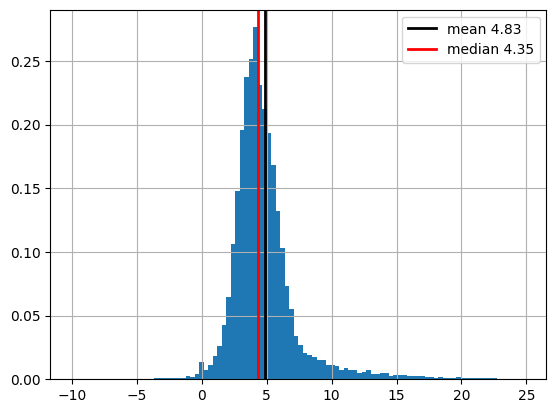

In [32]:
#final_data.hist(bins=100)
final_data
#don't plot the outliers
#density helps normalize it 
#final_data.loc[(final_data < 30 ) & (final_data > -20)].hist(bins=100, density=True) 

lower = -10
upper = 25
without_outliers = final_data.loc[(final_data < upper ) & (final_data > lower)]
without_outliers.mean()
without_outliers.hist(bins=100, density=True) 

#Removing the outliers is a sanity check to see if we are altering the data too much

import matplotlib.pyplot as plt
plt.axvline(final_data.mean(), c="black", lw=2, label=f"mean {final_data.mean():.2f}")
plt.axvline(final_data.median(), c="red", lw=2, label=f"median {final_data.median():.2f}")
plt.legend()

In [33]:
housedata["CAGR"] = housedata.apply(cagr_limits, axis = 1)
housedata.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,...,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,CAGR
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,107184.0,...,261757.0,267452.0,273750.0,279865.0,284916.0,288326.0,290250.0,290894.0,291871.0,4.498842
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,223094.0,...,454220.0,465824.0,479498.0,490869.0,498347.0,500609.0,498747.0,499289.0,501368.0,3.621100
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,90164.0,...,177626.0,179773.0,183128.0,186726.0,190164.0,192396.0,194095.0,195477.0,197127.0,3.495866
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,186206.0,...,564481.0,566396.0,567898.0,570676.0,572891.0,574998.0,575933.0,578691.0,582277.0,5.135762
4,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,275596.0,...,750970.0,756670.0,759268.0,765087.0,770360.0,775517.0,778187.0,781268.0,787104.0,4.717849


In [35]:
# Assuming "filename" is a variable pointing to the file path
filename = "gz_2010_us_050_00_500k.json"

# The data is a JSON file but not a GEOJSON file, which is a strict subset of JSON
# As such, we can't use gpd.GeoDataFrame.from_file because that expects a correctly-formatted geo-type file
# So we read it as generic JSON first
with open(filename, "r", encoding = "ISO-8859-1") as f:
    data = json.loads(f.read())

# Then we use geopandas's from_features constructor to build a geodataframe correctly instead
# This works because most geo-like files contain a list of things called "features" which are effectively
# points, polygons, or other areas of interest
county_geometry = gpd.GeoDataFrame.from_features(data["features"])

# We can confirm it worked by looking at .head() which should show an interpreted set of columns
# For example, the "geometry" column should contain POLYGON objects, or objects of "geometry" types
# and not strings of text that look like polygons or geometries 
county_geometry.head()




,geometry,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA
0,"POLYGON ((-85.38872 33.91304, -85.38089 33.873...",0500000US01029,01,029,Cleburne,County,560.100
1,"POLYGON ((-86.03044 31.61894, -86.00409 31.619...",0500000US01031,01,031,Coffee,County,678.972
2,"POLYGON ((-86.00928 33.10164, -86.00917 33.090...",0500000US01037,01,037,Coosa,County,650.926
3,"POLYGON ((-86.34851 30.99434, -86.35023 30.994...",0500000US01039,01,039,Covington,County,1030.456
4,"POLYGON ((-86.14699 31.68045, -86.14711 31.663...",0500000US01041,01,041,Crenshaw,County,608.840


geometry      geometry
GEO_ID          object
STATE           object
COUNTY          object
NAME            object
LSAD            object
CENSUSAREA     float64
dtype: object


<AxesSubplot: >

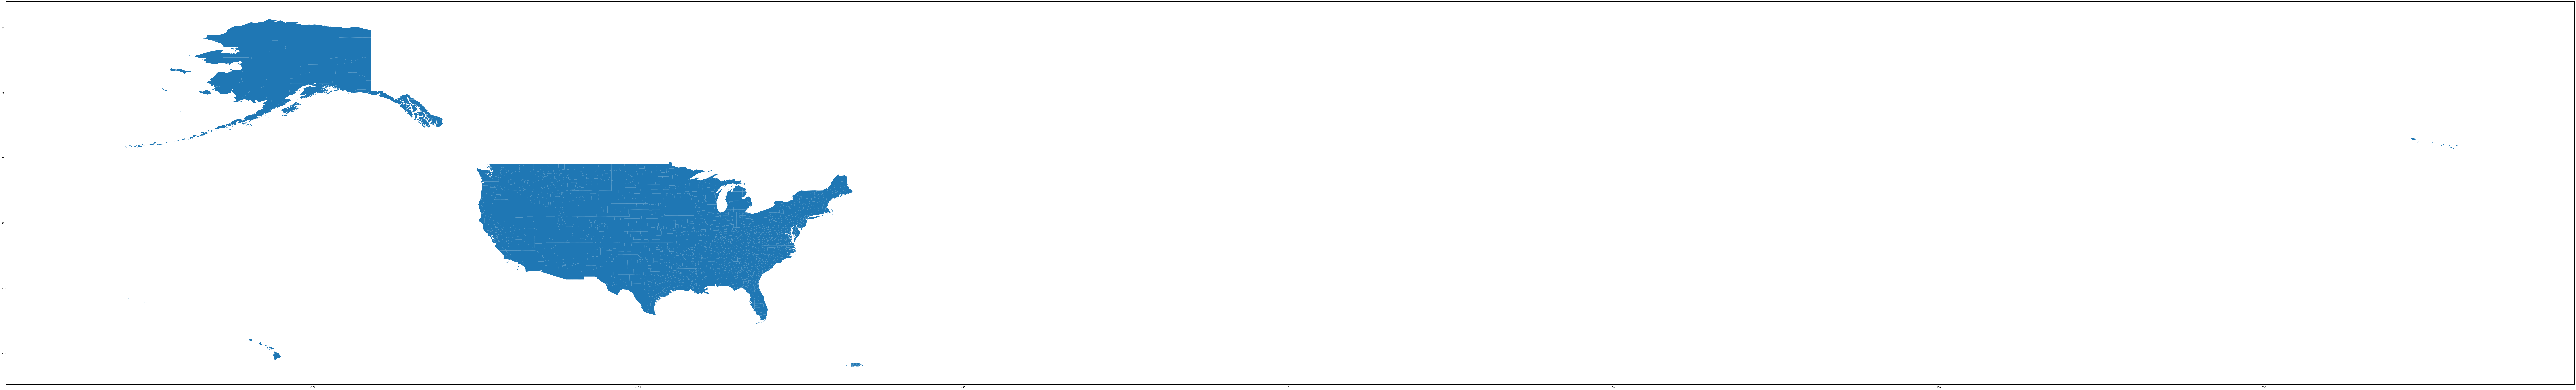

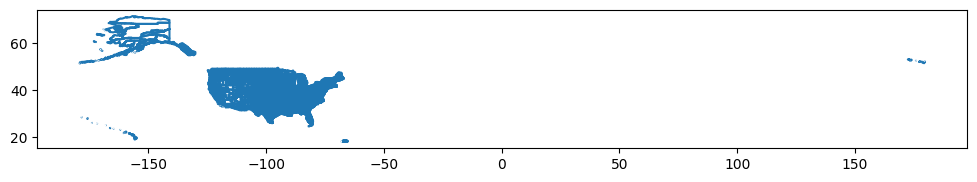

In [36]:
# To confirm, try df.dtypes and look at the dtype of the geometry column
print(county_geometry.dtypes)

# Once we're happy, a final sanity check might be visualising the data
# In geopandas, the .plot() method plots geographical objects, so let's just do that
county_geometry.plot(figsize=(200, 200))

# You can plot just the boundaries like this
county_geometry.boundary.plot(figsize=(12, 12))

In [37]:
county_table = pd.read_csv(r'county.txt', names=['State', 'StateFips', 'CountyFips', 'County Name', 'H'])
print(county_table)

     State  StateFips  CountyFips        County Name   H
0       AL          1           1     Autauga County  H1
1       AL          1           3     Baldwin County  H1
2       AL          1           5     Barbour County  H1
3       AL          1           7        Bibb County  H1
4       AL          1           9      Blount County  H1
...    ...        ...         ...                ...  ..
3230    PR         72         153    Yauco Municipio  H1
3231    UM         74         300     Midway Islands  H4
3232    VI         78          10   St. Croix Island  H4
3233    VI         78          20    St. John Island  H4
3234    VI         78          30  St. Thomas Island  H4

[3235 rows x 5 columns]


In [38]:
#county_table.head()

#identify duplicate rows
#duplicateRows = county_table[county_table.duplicated(['State','County Name'])]

#view duplicate rows
#print(duplicateRows)

#housedata.merge?
housedata_fips = pd.merge(housedata, county_table, left_on=['State','CountyName'], right_on = ['State','County Name'])
#print(housedata_fips)

county_geometry.rename(columns = {'STATE':'StateFips', 'COUNTY':'CountyFips'}, inplace = True)
county_geometry.head()
county_geometry['StateFips'] = county_geometry['StateFips'].astype(int)
county_geometry['CountyFips'] = county_geometry['CountyFips'].astype(int)

big_plot_2 = pd.merge(housedata_fips, county_geometry, left_on=['StateFips','CountyFips'], right_on = ['StateFips','CountyFips'])

#big_plot_2 = states.merge(housedata, left_on = "NAME", right_on = "StateName" )

In [39]:
big_plot_2.shape

(26745, 293)

(-180.0, -60.0)

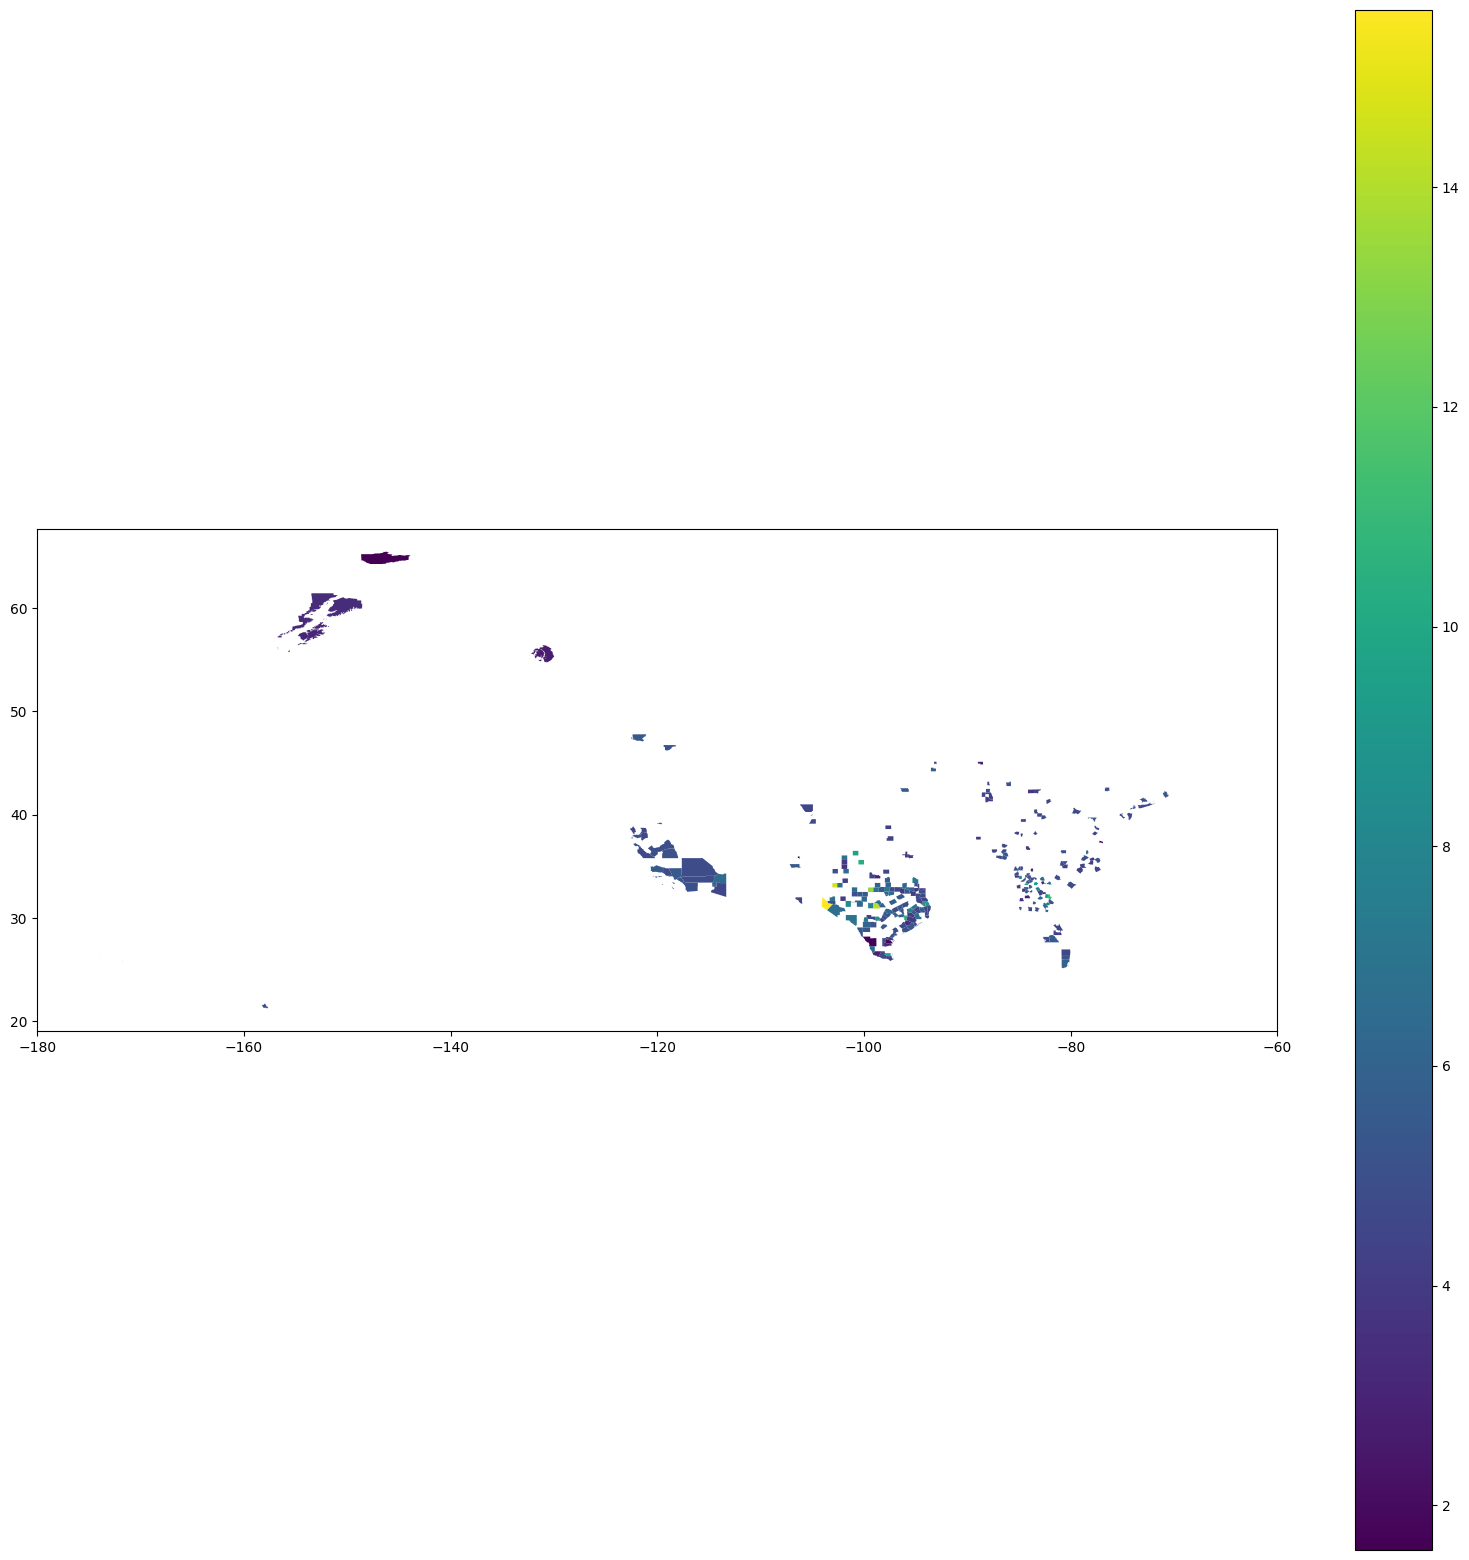

In [40]:
grouped_big_plot_county = gpd.GeoDataFrame(big_plot_2.groupby("CountyFips").agg({"CAGR":"mean","geometry":"first"}))


#big_plot.plot(column="CAGR")
grouped_big_plot_county.plot(column="CAGR", figsize=(20,20), legend=True)
plt.xlim(-180,-60)